# Estimating archaic TMRCAs from the real data

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(scales)
library(lemon)
library(cowplot)

devtools::load_all(".")
})

plan(multiprocess)

Loading ychr


### Estimate TMRCA of A00 and present-day non-Africans

In [2]:
highcov_gt <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = 3, maxdp = 0.975)

In [3]:
step1 <- run_step1(highcov_gt)

In [4]:
step1 %>% summarise_if(is.numeric, mean)

a,b,c,d,e,f,total,mut_rate,tmrca_afr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
964.6154,0.1538462,7.384615,194.4615,11.84615,986.3846,5677799,7.14796e-10,244118.1


### Estimate TMRCA between archaic Y chromosomes and present-day humans

All variations of filtering, substitution types, coverage cutoffs...

In [5]:
tmrca_full_low <-
    map_dfr(c("den4", "den8", "spy1", "shotgun_mez2", "shotgun_spy1"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:8, function(dp) {
                read_genotypes(arch, "full", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only") %>%
                    run_step2(step1) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    }) %>% mutate(capture = "full")

In [6]:
tmrca_full_high <-
    map_dfr(c("mez2", "mez2_snpad"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:20, function(dp) {
                read_genotypes(arch, "full", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only") %>%
                    run_step2(step1) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    }) %>% mutate(capture = "full")

In [7]:
tmrca_full_subsampled <-
    map_dfr(paste0("mez2_dp", 1:10), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:10, function(dp) {
                read_genotypes(arch, "full", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only") %>%
                    run_step2(step1) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    }) %>% mutate(capture = "full")

In [8]:
tmrca_lippold <-
    map_dfr(c("elsidron2"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:20, function(dp) {
                read_genotypes(arch, "lippold", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only") %>%
                    run_step2(step1) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    }) %>% mutate(capture = "lippold")

In [9]:
tmrca_exome <-
    map_dfr(c("elsidron1"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:8, function(dp) {
                read_genotypes(arch, "exome", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only") %>%
                    run_step2(step1) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    }) %>% mutate(capture = "exome")

In [10]:
tmrca_df <- bind_rows(tmrca_full_low, tmrca_full_high, tmrca_full_subsampled, tmrca_lippold, tmrca_exome)

In [13]:
saveRDS(tmrca_df, here("data/rds/tmrca_df.rds"))

In [9]:
tmrca_df <- readRDS(here("data/rds/tmrca_df.rds")) %>% mutate(afr = "a00")

### Heterogeneity in the `d` counts - uncertainty of the underlying Poisson process

In [6]:
tmrca_df %>% filter(dp == 3, arch == "den4", sites == "all") %>%
mutate(`alpha = (a + d) / d` = (a + d) / d) %>%
select(arch, ref, a, d, e, `alpha = (a + d) / d`, `tmrca = alpha * tmrca_A00` = tmrca_new, tmrca_afr, mut_rate) %>%
arrange(d)

arch,ref,a,d,e,alpha = (a + d) / d,tmrca = alpha * tmrca_A00,tmrca_afr,mut_rate
<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
den4,S_Turkish_1,249,114,216,3.184211,729068.7,228963.7,7.564197e-10
den4,S_Karitiana_1,250,115,216,3.173913,713409.1,224772.7,7.751377e-10
den4,S_Han_2,250,118,219,3.118644,828588.2,265688.6,6.506448e-10
den4,S_Thai_1,247,121,213,3.041322,807965.7,265662.7,6.530275e-10
den4,S_Punjabi_1,253,124,222,3.040323,796884.6,262105.3,6.660900e-10
den4,S_Burmese_1,250,126,215,2.984127,757371.4,253800.0,6.842820e-10
den4,S_French_1,254,128,214,2.984375,791218.9,265120.5,6.488345e-10
den4,S_Dai_2,252,129,216,2.953488,715819.6,242364.1,7.213230e-10
den4,S_Papuan_2,253,130,218,2.946154,704713.7,239197.9,7.302763e-10


### Minimum coverage cutoff vs branch counts (how low can we go?)

There needs to be a balance between:

* avoiding false SNPs due to low coverage
* mapping only reference-like sites

The `f` branch (length of the private archaic lineage) is a good measure for this. It is expected to be very long when the lower cutoff is low (for example, all DNA damage and sequencing errors will manifest as true SNPs when using even single reads), but shorten as we increase the cutoff. The danger is, of course, that a very strict filtering cutoff will allow only sites in reference-like regions to be considered.

Using the `e` branch counts as in Mendez et al. unreliable, because it changes significantly with coverage cutoffs. Luckily, the `d` and `a` branches become relatively stable with lower coverage cutoff as low as 3X. It is easy to derive a formula for $\alpha$ that avoid `e` completely.

In [6]:
dp_branches <- tmrca_df %>%
    mutate(arch = str_replace(arch, "mez2_dp(\\d+)", "\\1X"),
           arch = factor(arch, levels = paste0(1:8, "X"))) %>%
    filter(capture == "full", arch %in% paste0(1:8, "X"), sites == "all", dp <= 7) %>%
    mutate(n_muts = a + b + c + d + e + f) %>%
    select(arch, dp, a, b, c, d, e, f, total, n_muts, sites) %>%
    gather(branch, count, -c(arch, dp, total, n_muts, sites)) %>% 
    mutate(prop = count / n_muts,
           dp = factor(dp))

In [7]:
dp_branches_top <- dp_branches %>% select(arch, dp, sites, branch, prop) %>% group_by(arch, dp, sites, branch) %>% top_n(1, prop) %>% rename(max_prop = prop)
dp_branches_bottom <- dp_branches %>% select(arch, dp, sites, branch, prop) %>% group_by(arch, dp, sites, branch) %>% top_n(-1, prop) %>% rename(min_prop = prop)

Joining, by = c("arch", "dp", "sites", "branch")
Warning message:
“Removed 24 rows containing missing values (geom_point).”Warning message:
“Removed 24 rows containing missing values (geom_point).”

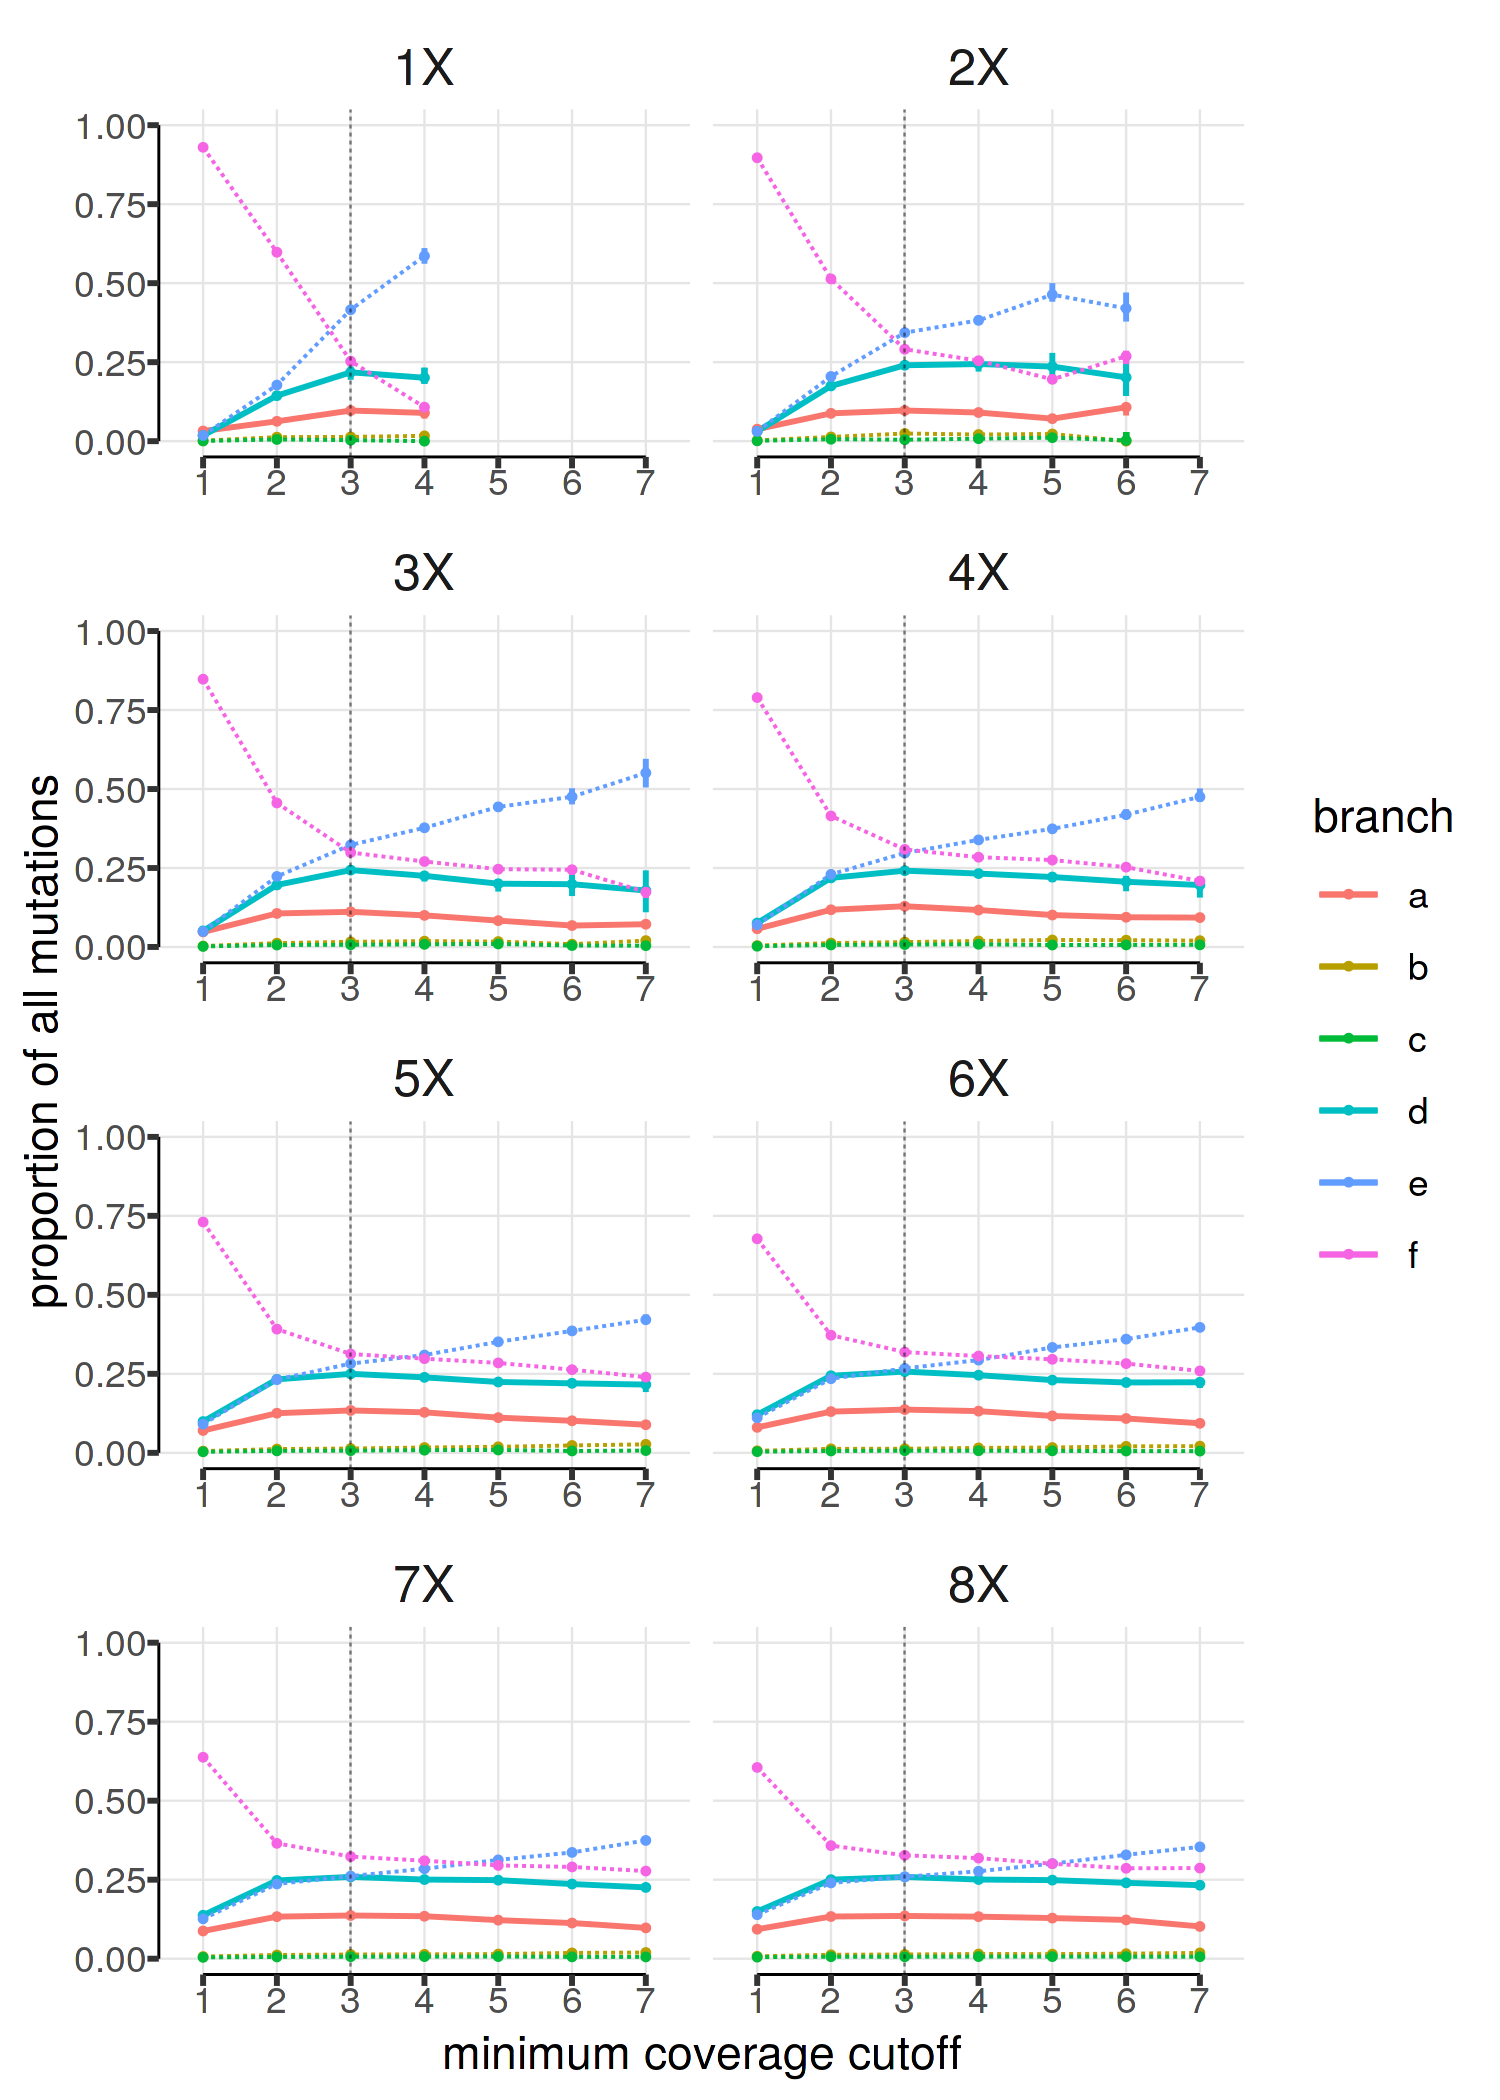

In [8]:
set_dim(5, 7)

ggplot() +
    geom_errorbar(data = inner_join(dp_branches_top, dp_branches_bottom),
                  aes(x = dp, ymin = min_prop, ymax = max_prop, color = branch), width = 0) +
    geom_line(data = filter(dp_branches, branch %in% c("a", "d")) %>%
                            group_by(arch, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 1) +
    geom_line(data = filter(dp_branches, !branch %in% c("a", "d")) %>%
                            group_by(arch, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 2, size = 1/3) +
    geom_point(data = group_by(dp_branches, arch, dp, sites, branch) %>% summarise_if(is.numeric, mean),
               aes(dp, prop, color = branch), size = 1/3) +
    geom_vline(xintercept = 3, linetype = 2, size = 1/5, alpha = 1/2, color = "black") +
    theme_bw() +
    theme(
        panel.border=element_blank(), 
        strip.text.x = element_text(size = 12),
        strip.background = element_blank(),
        axis.line = element_line(size = 1/4),
        legend.position = "right"
    ) +
    xlab("minimum coverage cutoff") +
    ylab("proportion of all mutations") +
    background_grid(major = "xy", minor = "none") +
    coord_capped_cart(ylim = c(0, 1), bottom = "both", left = "both") +
    facet_wrap(~ arch, ncol = 2, scales = "free_x") +
    guides(col = guide_legend(ncol = 1), linetype = FALSE)

ggsave(here("figures/branch_proportions_dp.png"), width = 5, height = 7)

### Same analysis but for all archaic Y chromosomes

In [186]:
arch_branches <- tmrca_df %>%
    filter(capture == "lippold" & arch == "elsidron2" |
           capture == "full" & arch %in% c("mez2", "spy1", "den4", "den8"),
           sites == "all", dp <= 7) %>%
    mutate(arch = fix_name(arch)) %>%
    mutate(n_muts = a + b + c + d + e + f) %>%
    select(arch, dp, a, b, c, d, e, f, total, n_muts, sites) %>%
    gather(branch, count, -c(arch, dp, total, n_muts, sites)) %>% 
    mutate(prop = count / n_muts,
           dp = factor(dp)) %>%
    mutate(arch = fct_relevel(arch, "El Sidrón 1253", "Spy 1", after = Inf))

In [187]:
arch_branches_top    <- select(arch_branches, arch, dp, sites, branch, prop) %>% group_by(arch, dp, sites, branch) %>% top_n(1, prop) %>% rename(max_prop = prop)
arch_branches_bottom <- select(arch_branches, arch, dp, sites, branch, prop) %>% group_by(arch, dp, sites, branch) %>% top_n(-1, prop) %>% rename(min_prop = prop)

Joining, by = c("arch", "dp", "sites", "branch")
Warning message:
“Removed 4 rows containing missing values (geom_path).”Warning message:
“Removed 8 rows containing missing values (geom_path).”Warning message:
“Removed 18 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_path).”Warning message:
“Removed 8 rows containing missing values (geom_path).”Warning message:
“Removed 18 rows containing missing values (geom_point).”

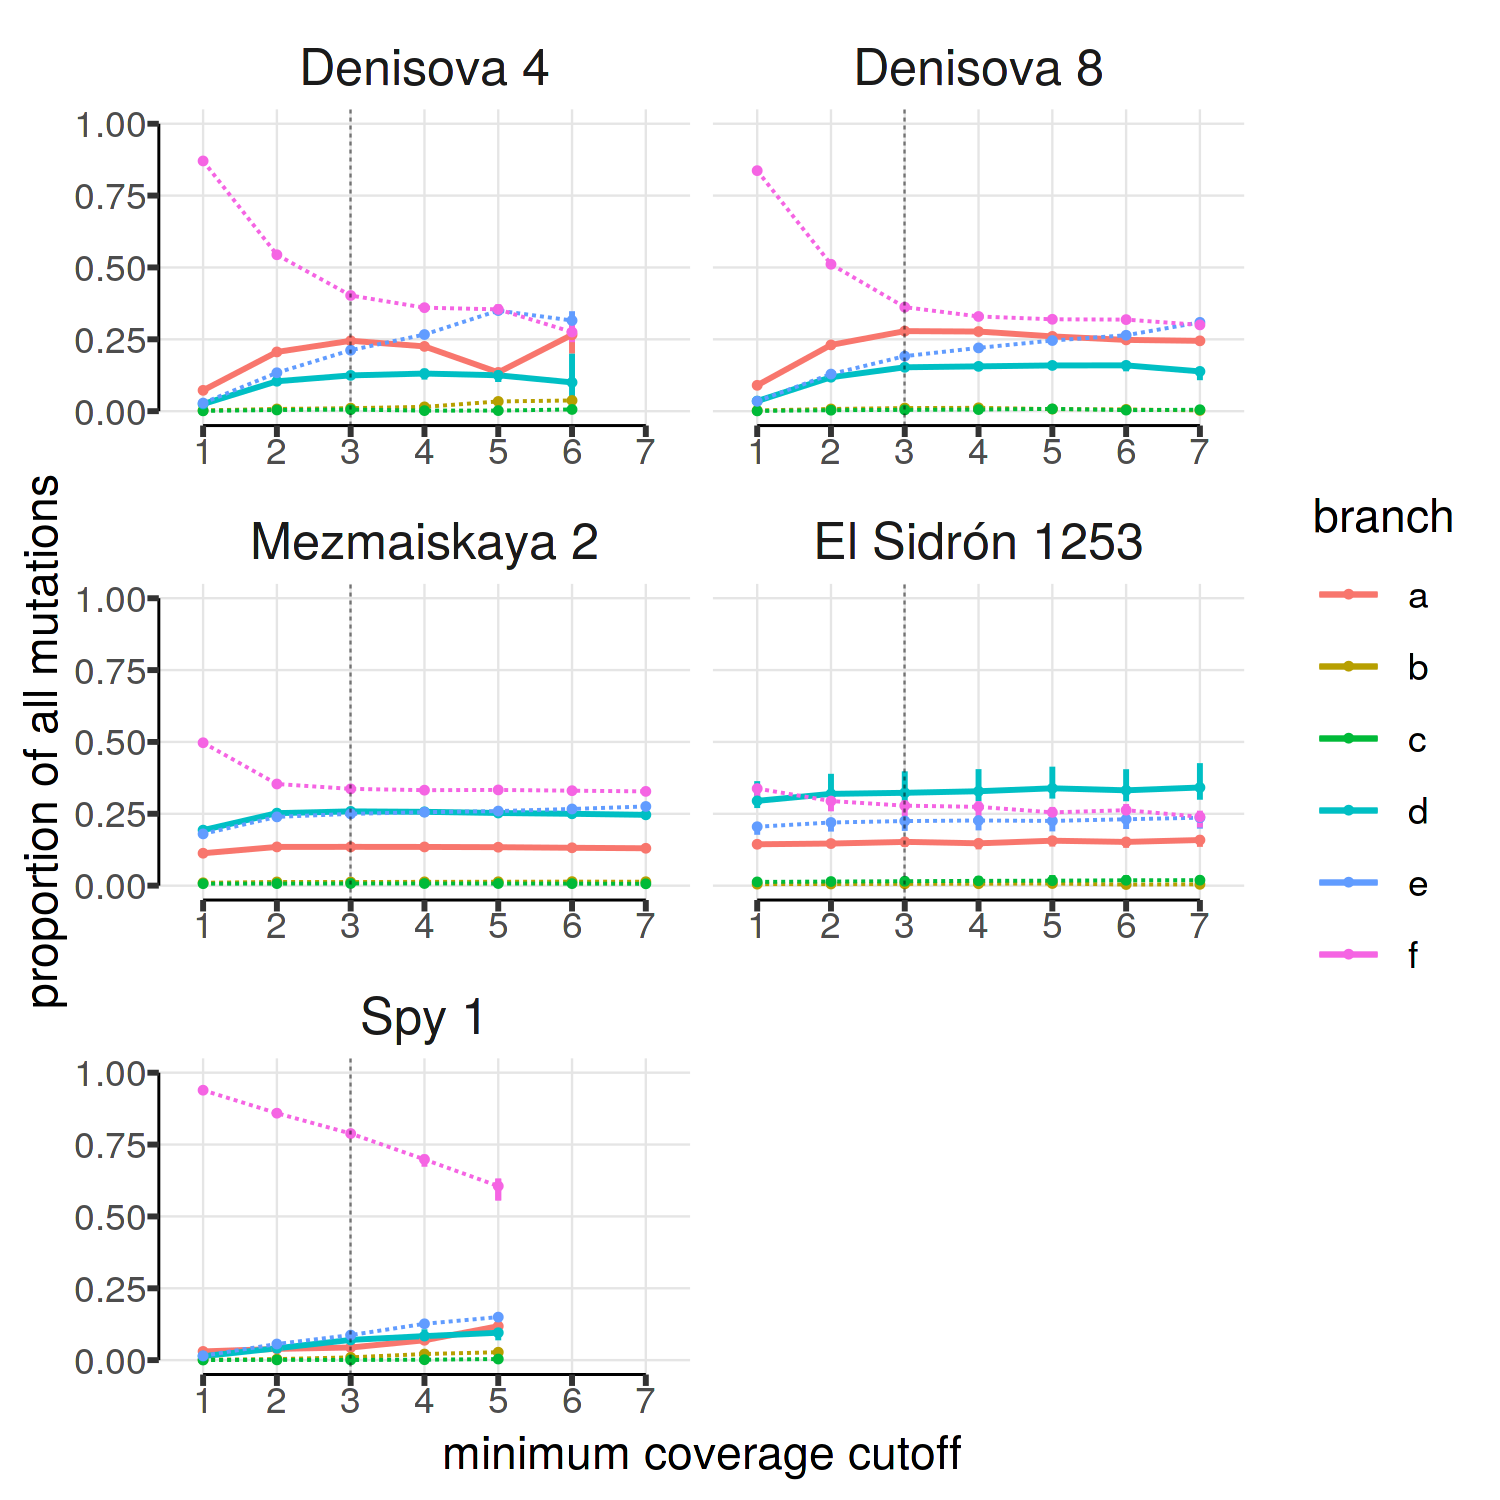

In [188]:
set_dim(5, 5)

ggplot() +
    geom_errorbar(data = inner_join(arch_branches_top, arch_branches_bottom),
                  aes(x = dp, ymin = min_prop, ymax = max_prop, color = branch), width = 0) +
    geom_line(data = filter(arch_branches, branch %in% c("a", "d")) %>%
                            group_by(arch, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 1) +
    geom_line(data = filter(arch_branches, !branch %in% c("a", "d")) %>%
                            group_by(arch, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 2, size = 1/3) +
    geom_point(data = group_by(arch_branches, arch, dp, sites, branch) %>% summarise_if(is.numeric, mean),
               aes(dp, prop, color = branch), size = 1/3) +
    geom_vline(xintercept = 3, linetype = 2, size = 1/5, alpha = 1/2, color = "black") +
    theme_bw() +
    theme(
        panel.border=element_blank(), 
        strip.text.x = element_text(size = 12),
        strip.background = element_blank(),
        axis.line = element_line(size = 1/4),
        legend.position = "right"
    ) +
    xlab("minimum coverage cutoff") +
    ylab("proportion of all mutations") +
    background_grid(major = "xy", minor = "none") +
    coord_capped_cart(ylim = c(0, 1), bottom = "both", left = "both") +
    facet_wrap(~ arch, ncol = 2, scales = "free_x") +
    guides(col = guide_legend(ncol = 1), linetype = FALSE)

ggsave(here("figures/branch_proportions_arch.png"), width = 5, height = 5)

^^^ `a` and `f` appear to level after `dp >= 3` which seems OK???

but `e` is increasing steadily - this is super weird and could be driving `a / (a + d + e)` higher at higher cutoffs?
* is the increased proportion of `e` branch the reference bias signal?


# TMRCA estimates

In [238]:
# Filter sites/depth/capture regions/individuals
filter_tmrca <- function(stat, mindp, sites, exclude = NA) {
    filter(
        tmrca_df,
        sites == !!sites & dp == mindp & capture == "full" & arch %in% c("den4", "den8", "mez2", "spy1", "shotgun_spy1", "shotgun_mez2") |
        sites == !!sites & dp == mindp & capture == "lippold" & arch == "elsidron2" |
        dp %in% c(1, 3) & sites == "all" & capture == "exome" & arch == "elsidron1",
        !arch %in% exclude
    ) %>%
        mutate(arch = case_when(arch == "elsidron1" & dp == 1 ~ "elsidron_dp1",
                                arch == "elsidron1" & dp == 3 ~ "elsidron_dp3",
                                TRUE ~ arch))
}

In [239]:
# Combine archaic and A00 TMRCA data frames for further analysis
# Calculate confidence intervals for each reference individual by bootstrapping
get_ind_tmrca <- function(stat, mindp, sites, exclude = NA) {
    arch_ind_ci <- filter_tmrca(stat, mindp, sites, exclude) %>%
        add_step2_ci(per_ind = TRUE) %>%
        select(name = arch, ref, contains(stat)) %>%
        setNames(c("name", "ref", "tmrca", "high", "low"))

    afr_ind_ci <- step1 %>%
        add_step1_ci(per_ind = TRUE) %>%
        select(name = afr, ref, contains("tmrca_afr")) %>%
        filter(!name %in% exclude) %>%
        setNames(c("name", "ref", "tmrca", "high", "low"))

    bind_rows(arch_ind_ci, afr_ind_ci) %>% assign_set
}

In [240]:
get_overall_tmrca <- function(stat, mindp, sites, exclude = NA) {
    arch <- filter_tmrca(stat, mindp, sites, exclude)

    # overall archaic TMRCA values and CIs
    arch_overall <- arch %>%
        add_step2_ci(per_ind = FALSE) %>%
        select(name = arch, contains(stat)) %>%
        setNames(c("name", "tmrca", "high", "low"))
   
    # overall A00 TMRCA values and CIs
    afr_overall <- step1 %>%
        add_step1_ci(per_ind = FALSE) %>%
        select(name = afr, contains("tmrca_afr")) %>%
        filter(!name %in% exclude) %>%
        select(name, tmrca = tmrca_afr, low = tmrca_afr_low, high = tmrca_afr_high)

    bind_rows(arch_overall, afr_overall) %>% assign_set
}

Warning message:
“Unknown levels in `f`: Spy 1 (shotgun), Mezmaiskaya 2 (shotgun)”Warning message:
“Unknown levels in `f`: Spy 1 (shotgun), Mezmaiskaya 2 (shotgun)”

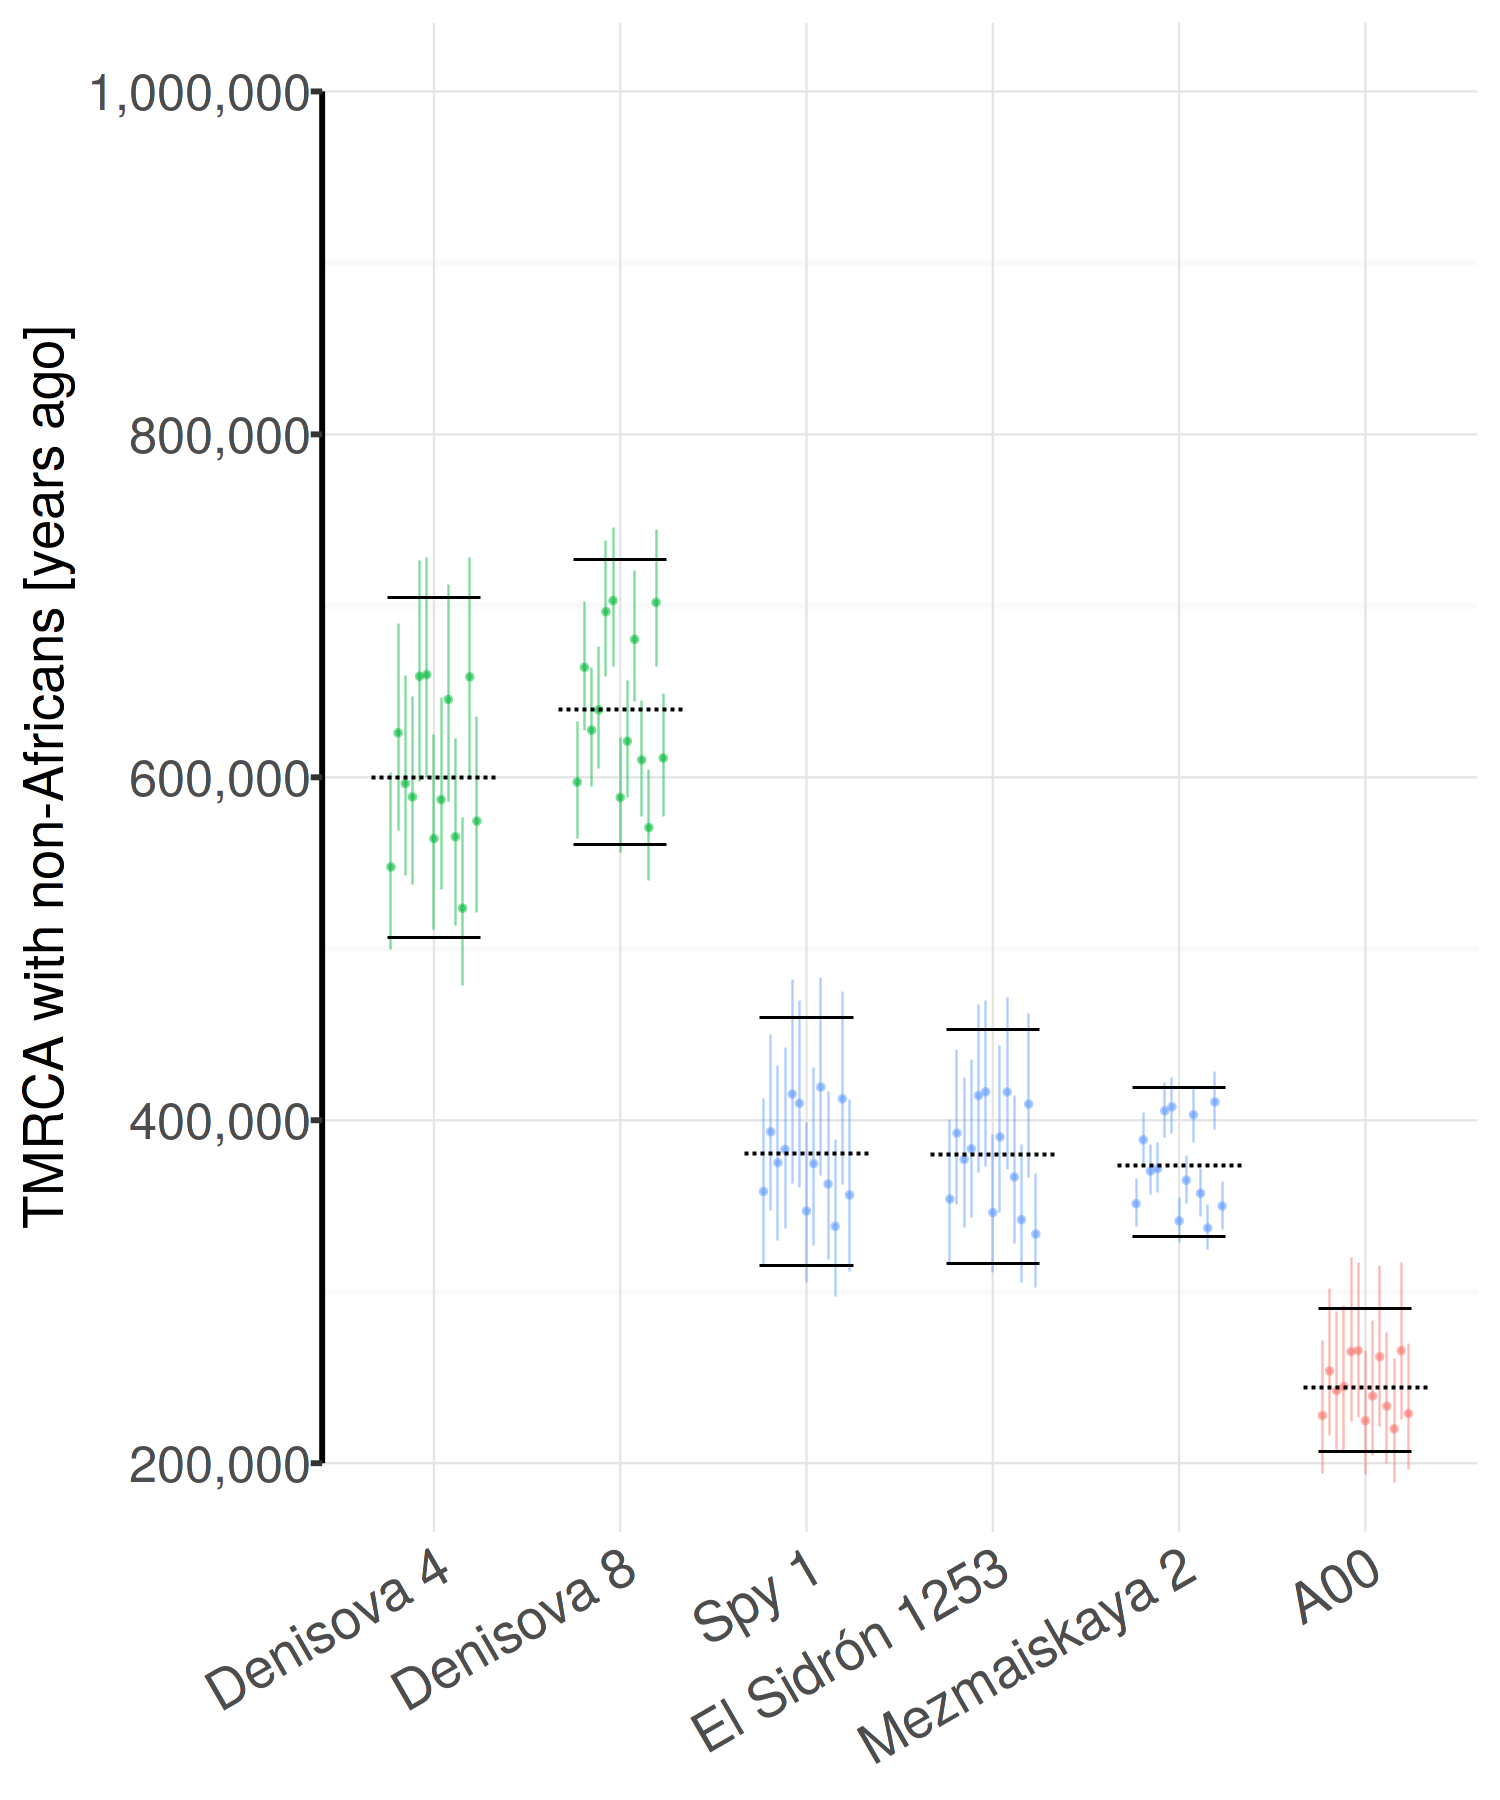

In [244]:
plot_tmrca <- function(stat, mindp, sites, exclude = NA) {
    ind_tmrca <- get_ind_tmrca(stat, mindp, sites, exclude)

    overall_tmrca <- get_overall_tmrca(stat, mindp, sites, exclude)

    ggplot() +
        # individual CIs
        geom_linerange(data = ind_tmrca, aes(name, ymin = low, ymax = high, group = ref, color = set),
                      position = position_dodge(width = 1/2), size = 1/5, alpha = 0.5) +

        # individual points
        geom_point(data = ind_tmrca, aes(name, tmrca, group = ref, color = set),
                      position = position_dodge(width = 1/2), size = 1/5, alpha = 0.5) +
        # average
        geom_segment(data = overall_tmrca, size = 1/3, linetype = 2,
                     aes(x = as.numeric(name) - 1/3, y = tmrca, xend = as.numeric(name) + 1/3, yend = tmrca)) +
        # upper bar
        geom_segment(data = overall_tmrca, size = 1/4,
                     aes(x = as.numeric(name) - 1/4, y = high, xend = as.numeric(name) + 1/4, yend = high)) +
        # lower bar
        geom_segment(data = overall_tmrca, size = 1/4,
                     aes(x = as.numeric(name) - 1/4, y = low, xend = as.numeric(name) + 1/4, yend = low)) +
        theme(axis.text.x = element_text(hjust = 1, angle = 45)) + 
        theme_classic() +
        ylab("TMRCA with non-Africans [years ago]") +
        scale_y_continuous(labels = comma) +
        theme(
            legend.position = "none",
            axis.text.x = element_text(hjust = 1, angle = 30, size = 13),
            axis.title.x = element_blank(),
            axis.line.x = element_blank(),
            axis.ticks.x = element_blank(),
            axis.text.y = element_text(size = 12),
            axis.title.y = element_text(size = 13)
        ) +
        background_grid(major = "xy", minor = "xy") +
        coord_capped_cart(ylim = c(200000, 1e6), left = "both")
}
plot_tmrca(stat = "mendez", mindp = 3, sites = "all", exclude = c("elsidron1", "shotgun_mez2", "shotgun_spy1"))

<br><br><br><br><br><br><br><br><br><br>

### TMRCA vs coverage

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Removed 13 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 12 rows containing missing values (geom_point).”

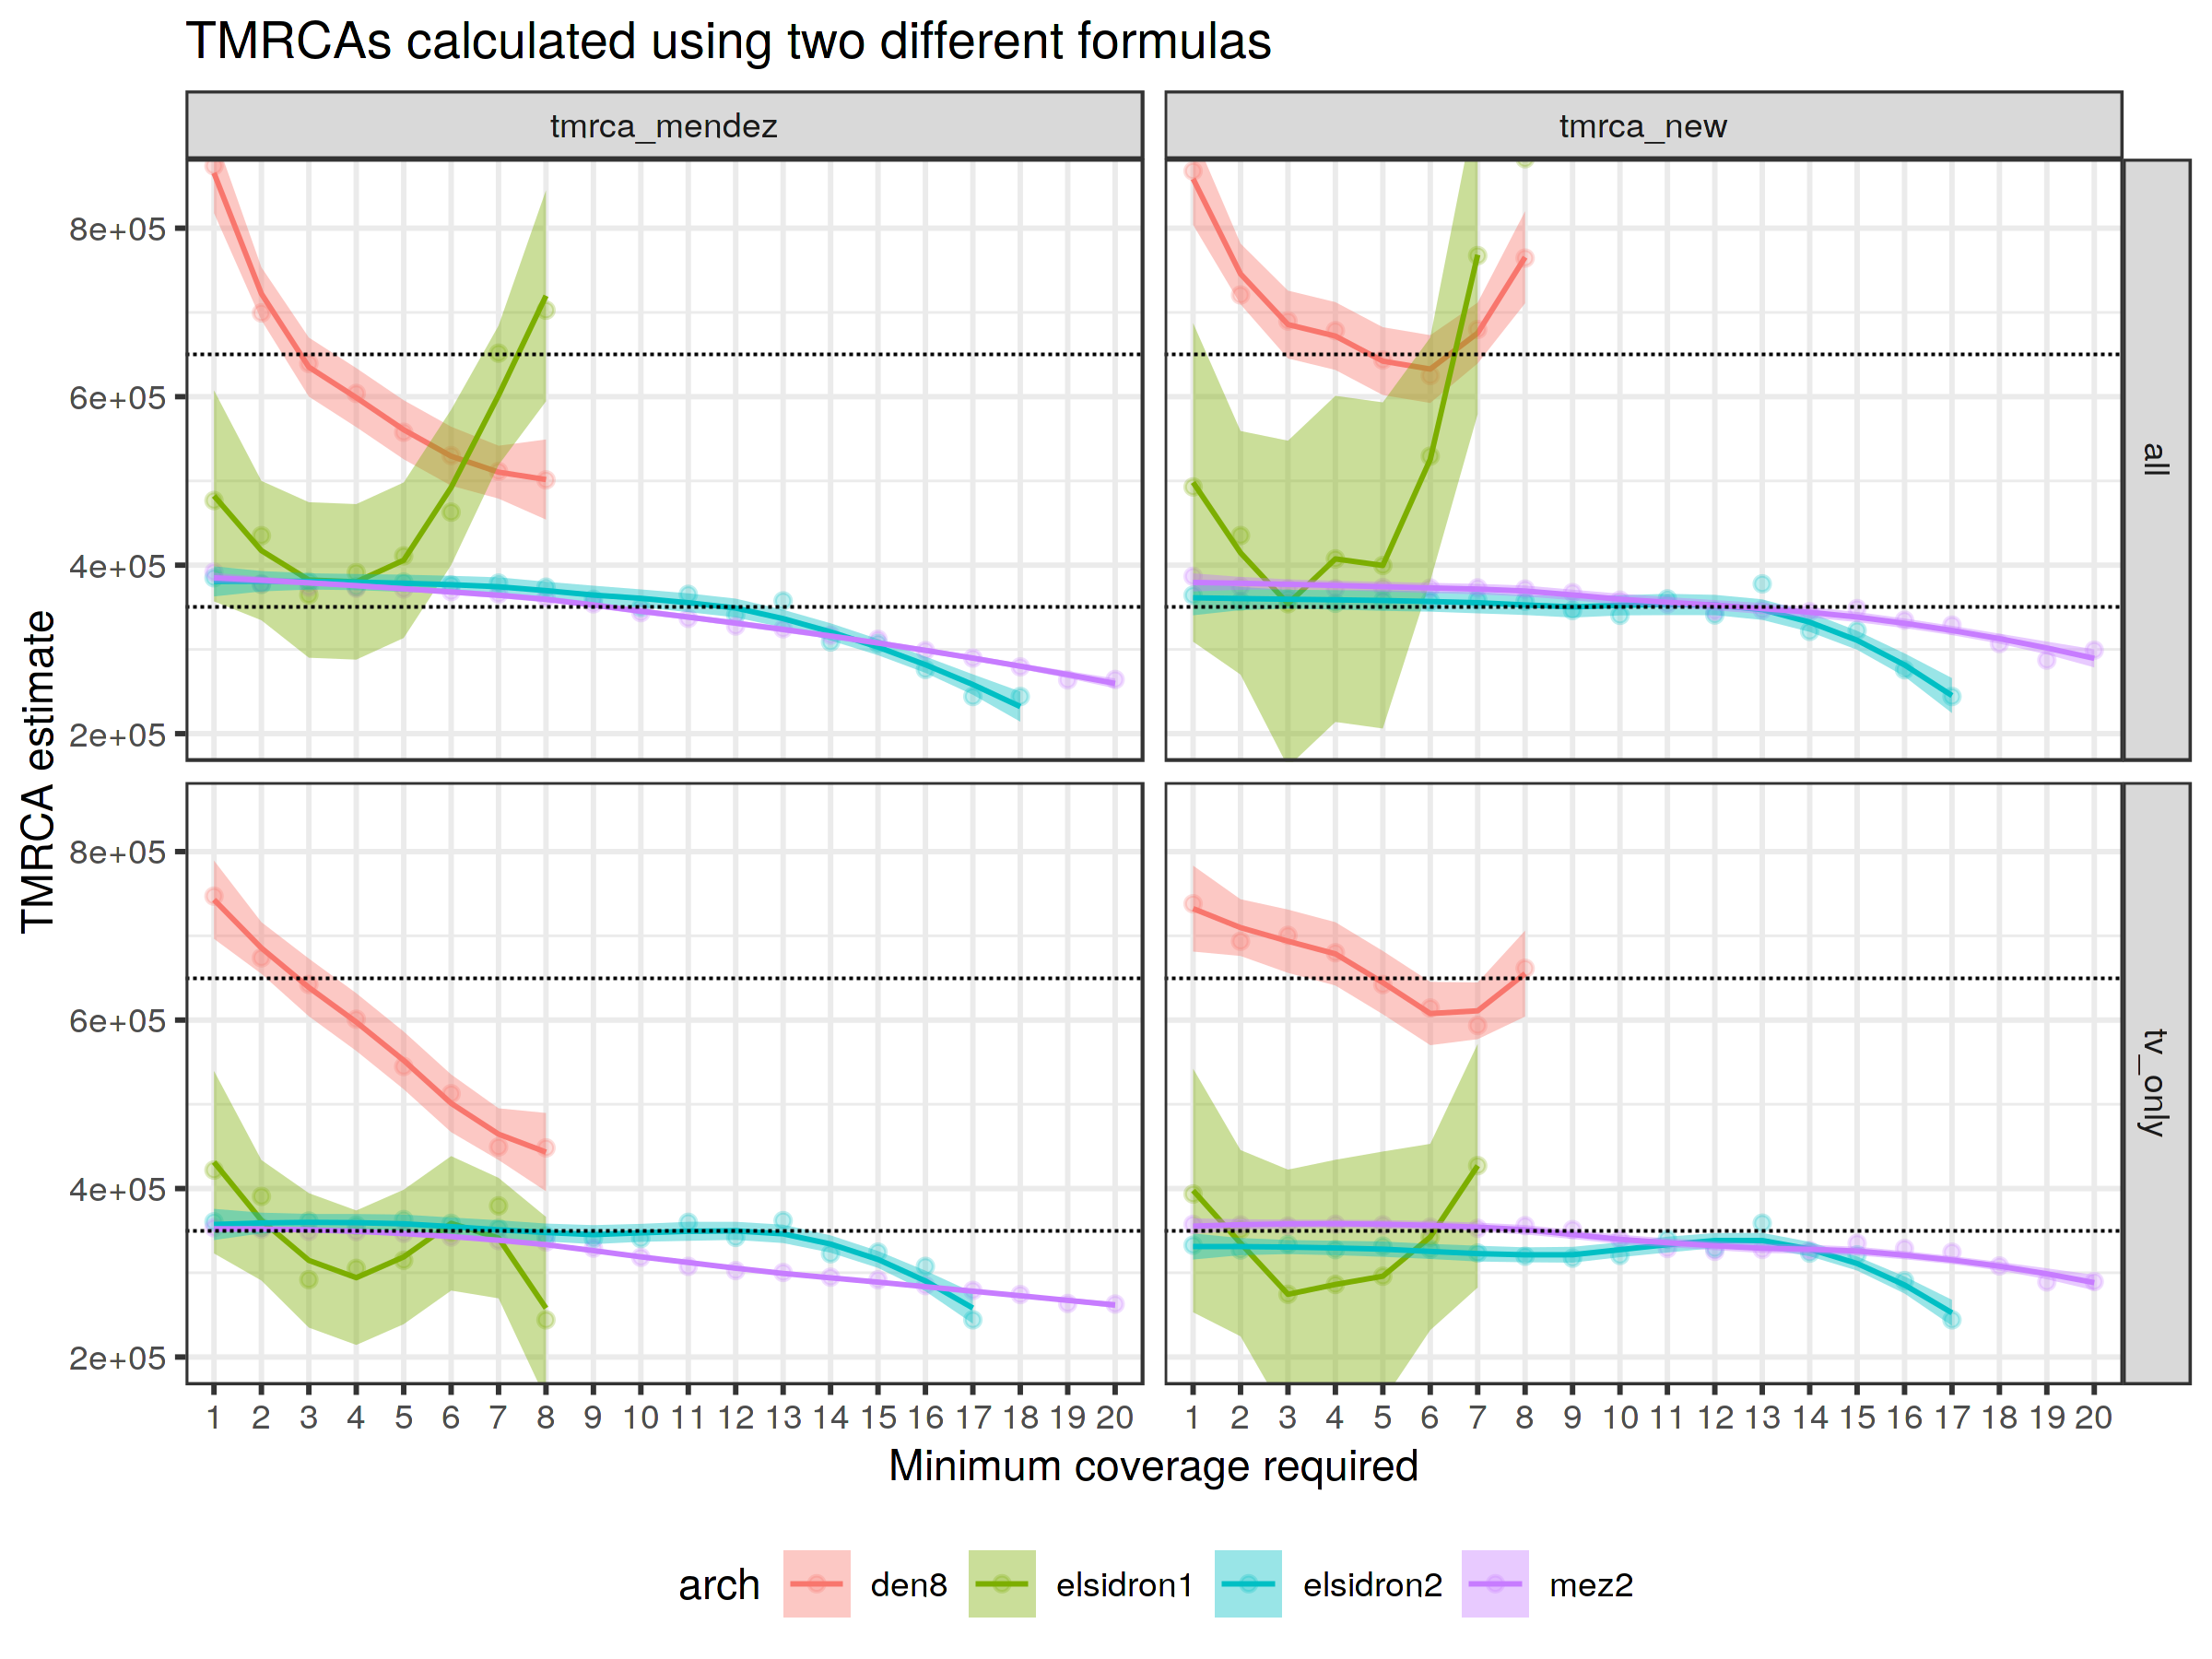

In [45]:
set_dim(8, 6)

tmrca_df %>%
filter(capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "elsidron2" | capture == "exome" & arch == "elsidron1") %>%
select(arch, tmrca_new, tmrca_mendez, sites, dp) %>%
group_by(arch, sites, dp) %>% summarise_all(mean) %>% 
gather(tmrca, value, -c(arch, sites, dp)) %>%
ggplot(aes(dp, value, color = arch)) +
    geom_point(aes(as.factor(dp), value), alpha = 1/4) +
    geom_smooth(aes(fill = arch), size = 0.5) +
    labs(x = "Minimum coverage required", y = "TMRCA estimate") +
    theme_bw() +
    coord_cartesian(y = c(200000, 850000)) +
    facet_grid(sites ~ tmrca) +
    theme(legend.position = "bottom") +
    ggtitle("TMRCAs calculated using two different formulas") +
    geom_hline(yintercept = c(350000, 650000), linetype = 2, size = 1/3)

# Why do `d` and `e` counts differ so much depending on coverage?

In [61]:
set_dim(6, 3)

tmrca_df %>%
filter(capture == "full" & arch %in% c("den8"), sites == "all") %>%
mutate(n_muts = a + b + c + d + e + f) %>% select(-starts_with("tmrca"), -mut_rate) %>%
group_by(arch, dp) %>%
summarise_if(is.numeric, mean) %>%
arrange(dp)

arch,dp,a,b,c,d,e,f,total,n_muts
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
den8,1,2196.23077,60.0000000,23.769231,860.00000,842.92308,20421.23077,4922851.8,24404.1538
den8,2,1274.61538,42.4615385,18.923077,653.23077,713.76923,2825.30769,4131211.1,5528.3077
den8,3,826.76923,32.2307692,13.461538,453.23077,568.38462,1074.15385,3228656.1,2968.2308
den8,4,510.92308,21.6153846,10.384615,287.61538,406.07692,607.61538,2342627.5,1844.2308
den8,5,282.92308,7.8461538,8.692308,173.15385,267.30769,347.69231,1572715.2,1087.6154
den8,6,154.15385,3.8461538,2.307692,99.15385,164.23077,198.07692,974624.4,621.7692
den8,7,78.07692,0.8461538,1.615385,44.23077,98.61538,95.76923,549088.7,319.1538
den8,8,37.23077,0.0000000,1.230769,18.07692,52.76923,45.69231,271434.3,155.0000


^^^ note that the `a` length is getting A LOT shorter as we increase the coverage cutoff

d/e ~1 for DP >= 1, as it should be, because there's no reason for them to be different, really

### The following means that the `a` branch is getting increasingly shorter than `e` the higher the required coverage cutoff is

But note that it's the same even for Mez2! Probably not archaic-caused ref bias?!

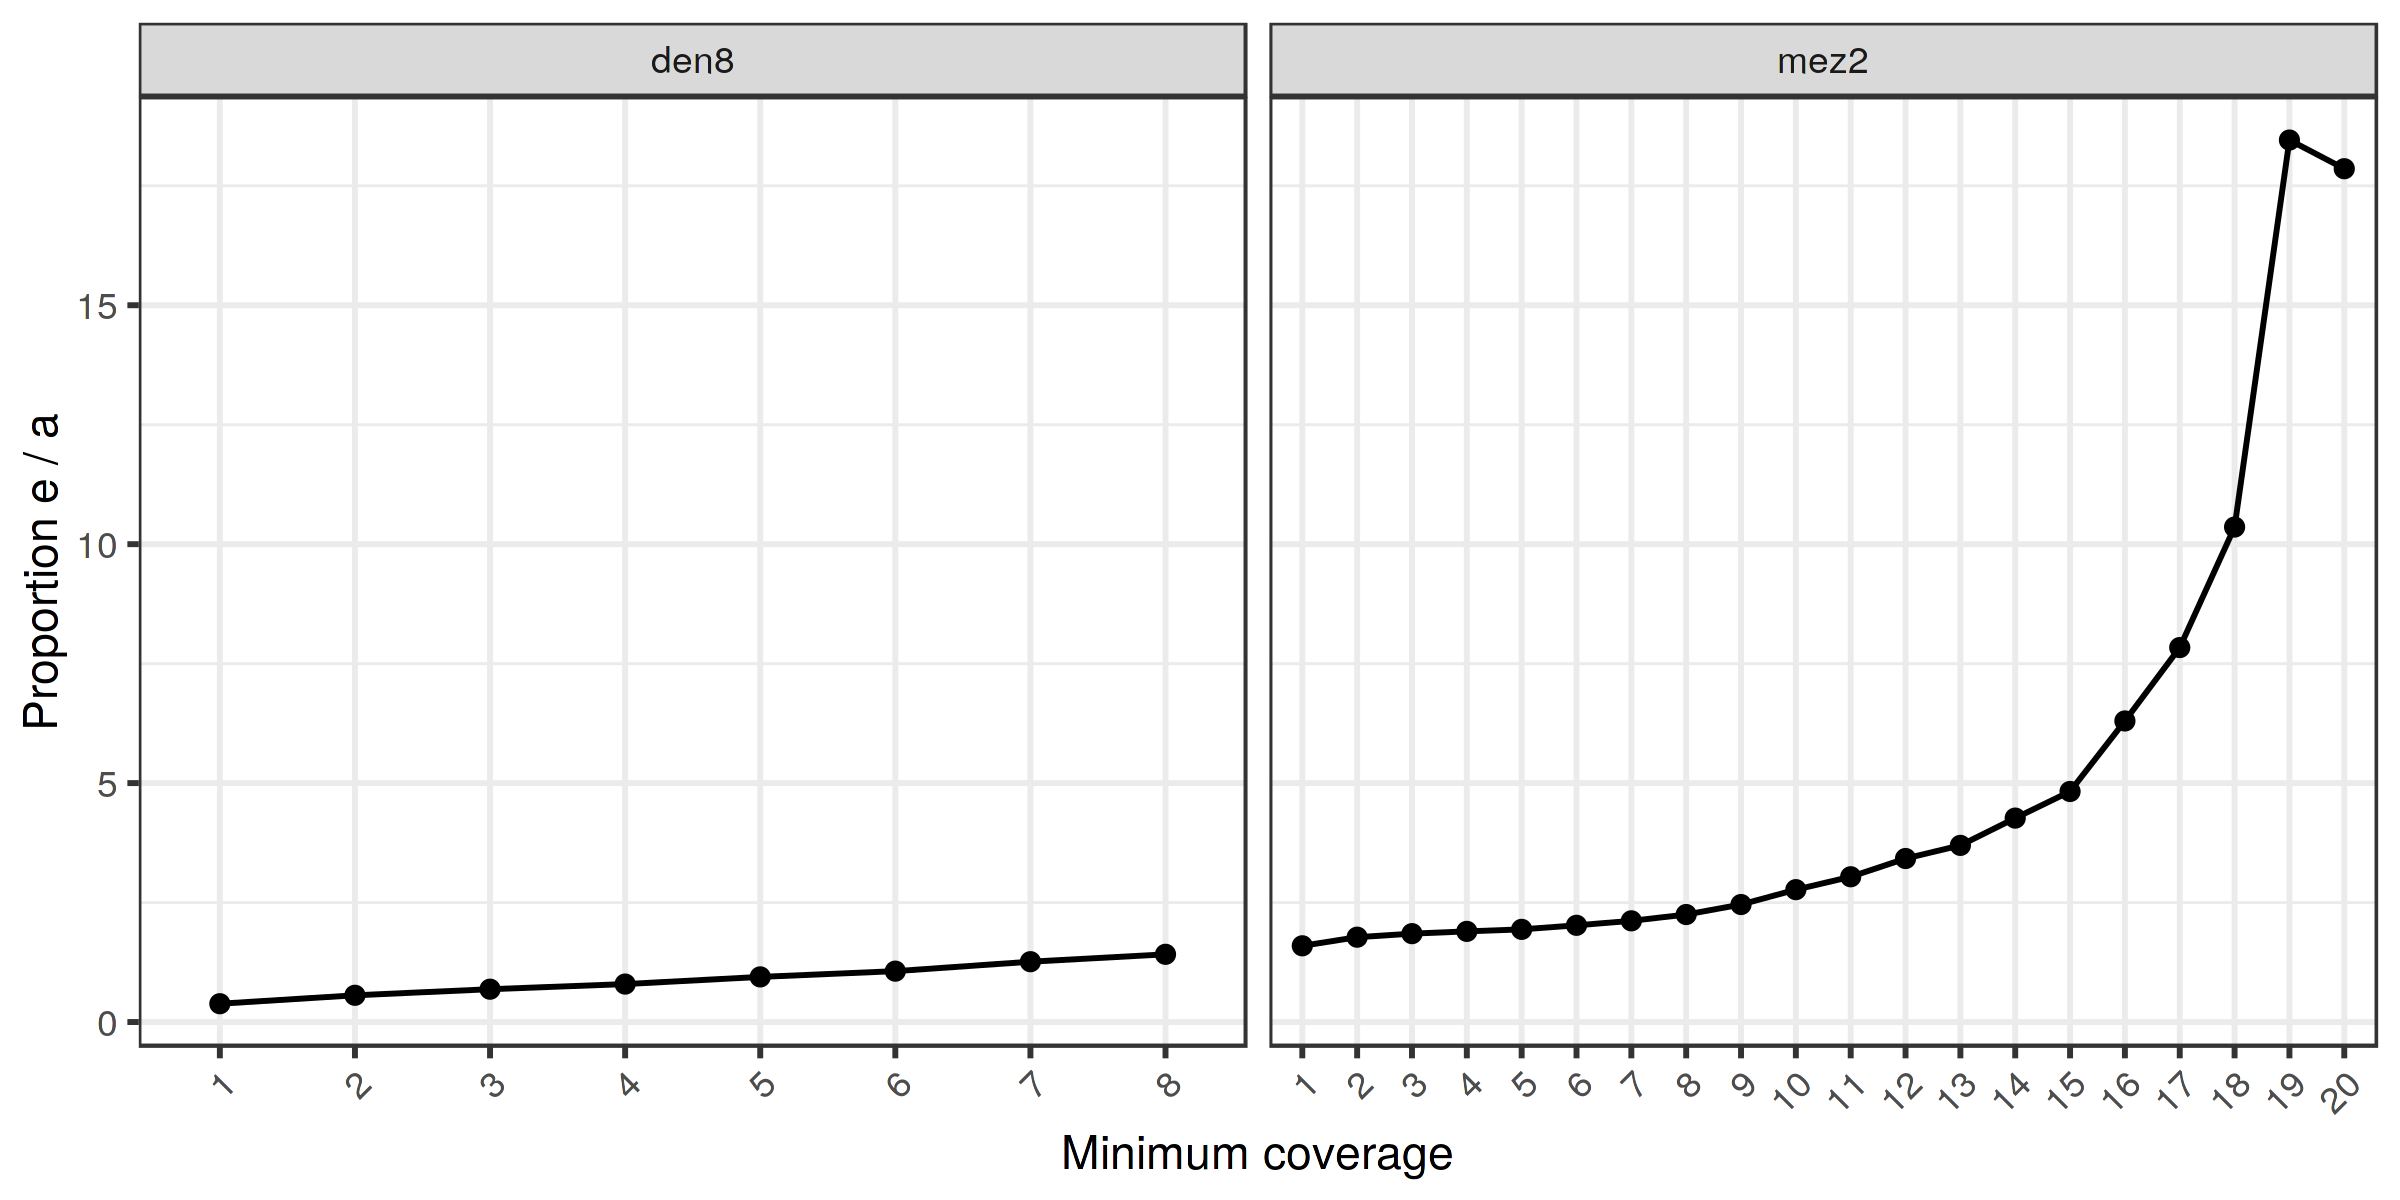

In [192]:
set_dim(8, 4)

tmrca_df %>%
filter(sites == "all", capture == "full" & arch %in% c("den8", "mez2")) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
group_by(arch, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = e / a) %>% 
ggplot(aes(as.factor(dp), prop)) +
    geom_point() +
    geom_line(group = 1) +
    facet_wrap(~ arch, scales = "free_x") +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion e / a") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

### ... but not the `d` branch... ?

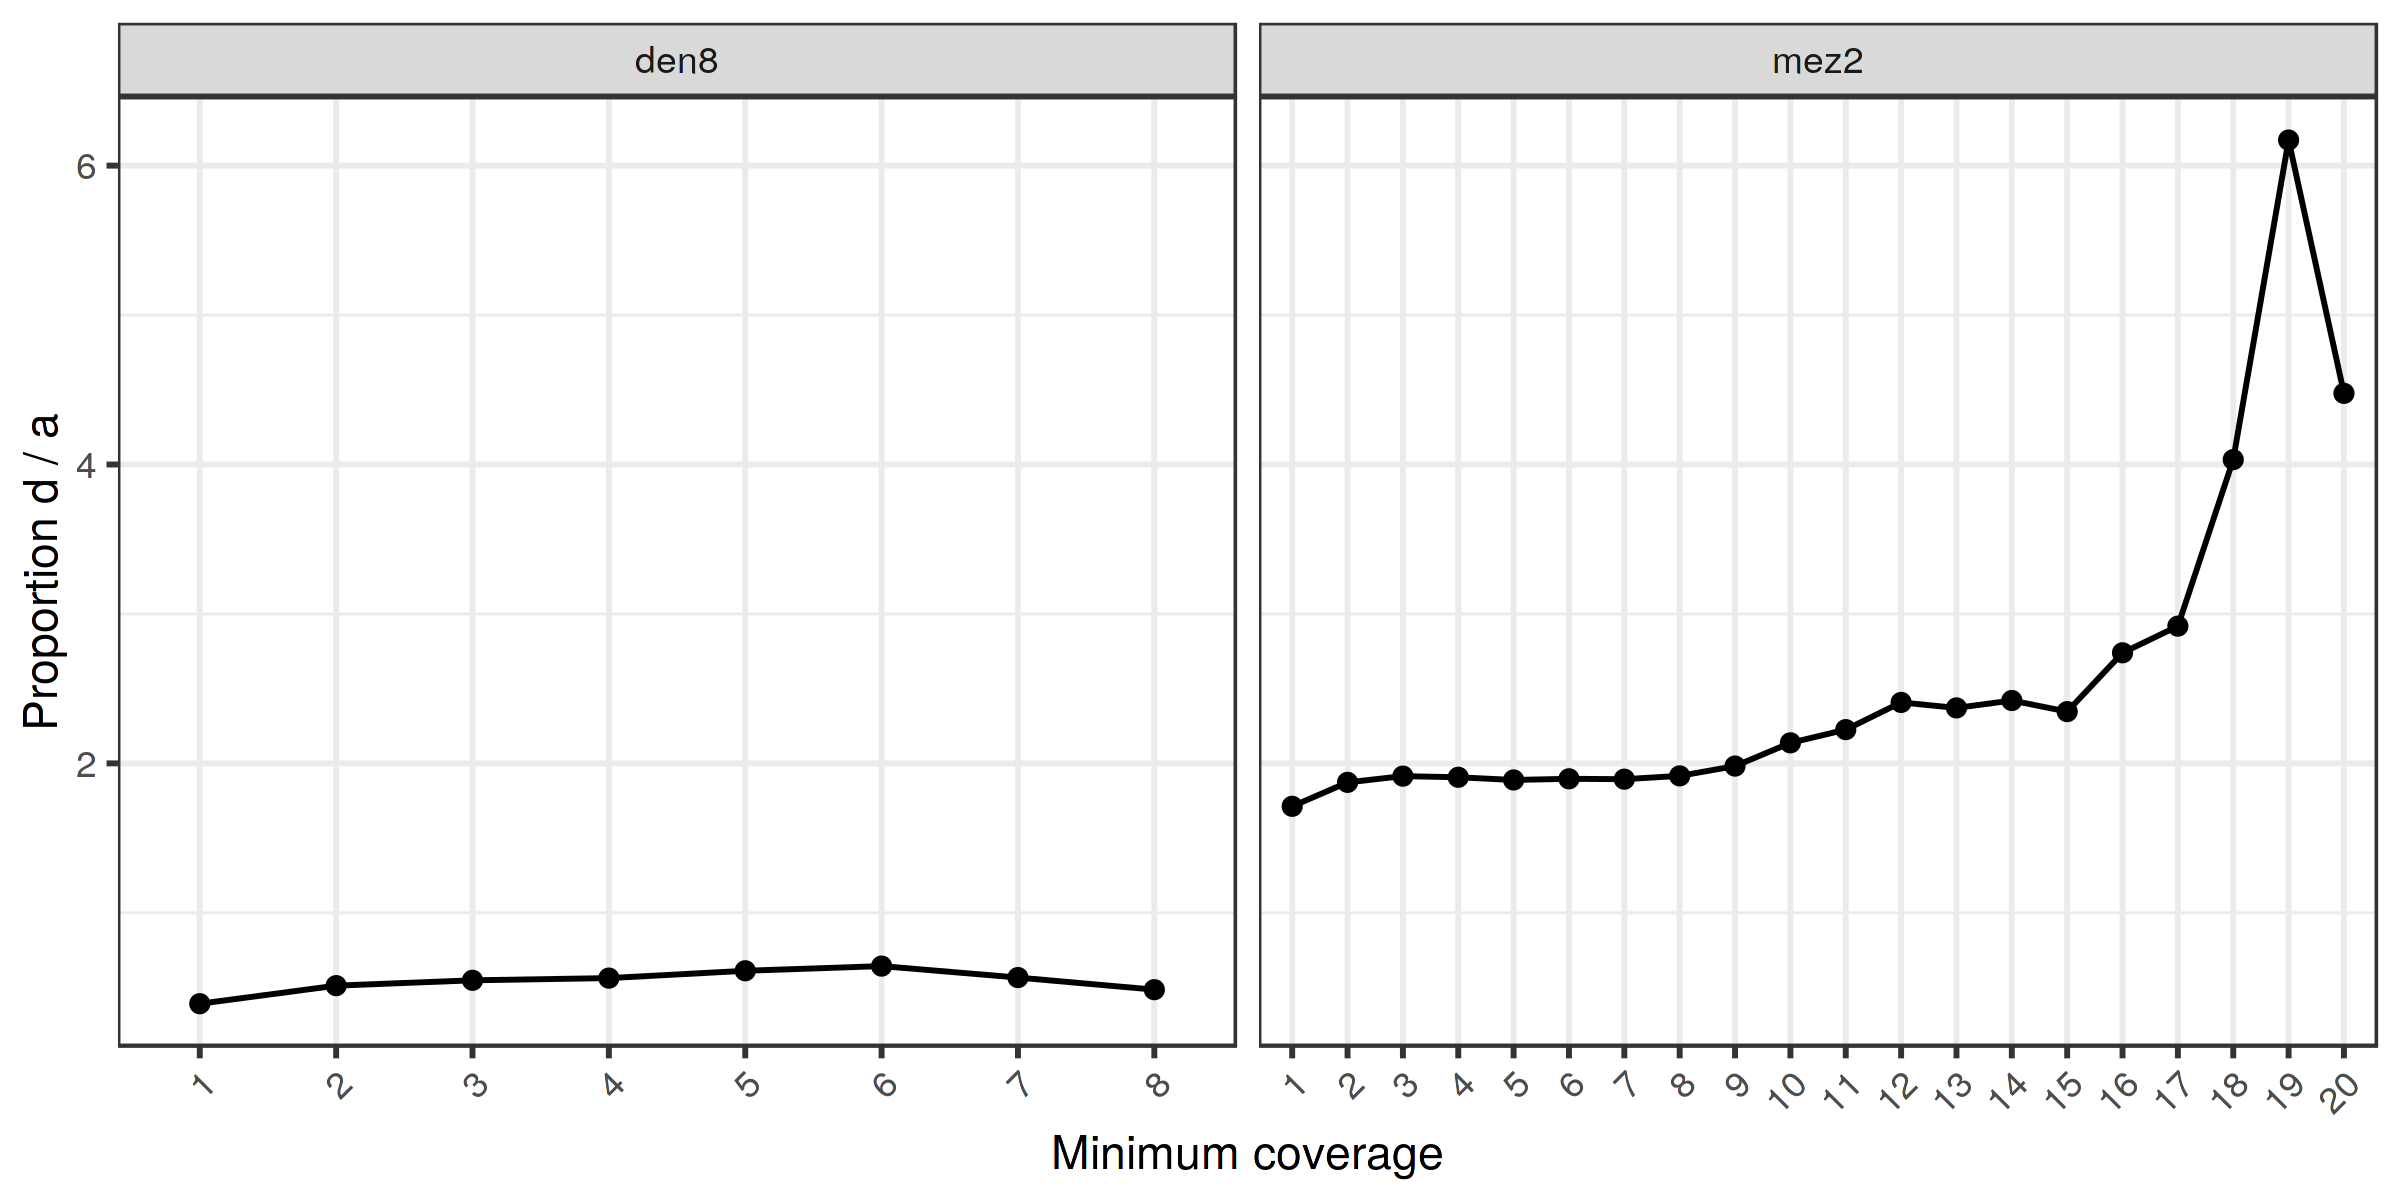

In [191]:
set_dim(8, 4)

tmrca_df %>%
filter(sites == "all", capture == "full" & arch %in% c("den8", "mez2")) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
group_by(arch, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = d / a) %>% 
ggplot(aes(as.factor(dp), prop)) +
    geom_point() +
    geom_line(group = 1) +
    facet_wrap(~ arch, scales = "free_x") +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion d / a") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

### What about `d` vs `e`? This proportion should be ~1.

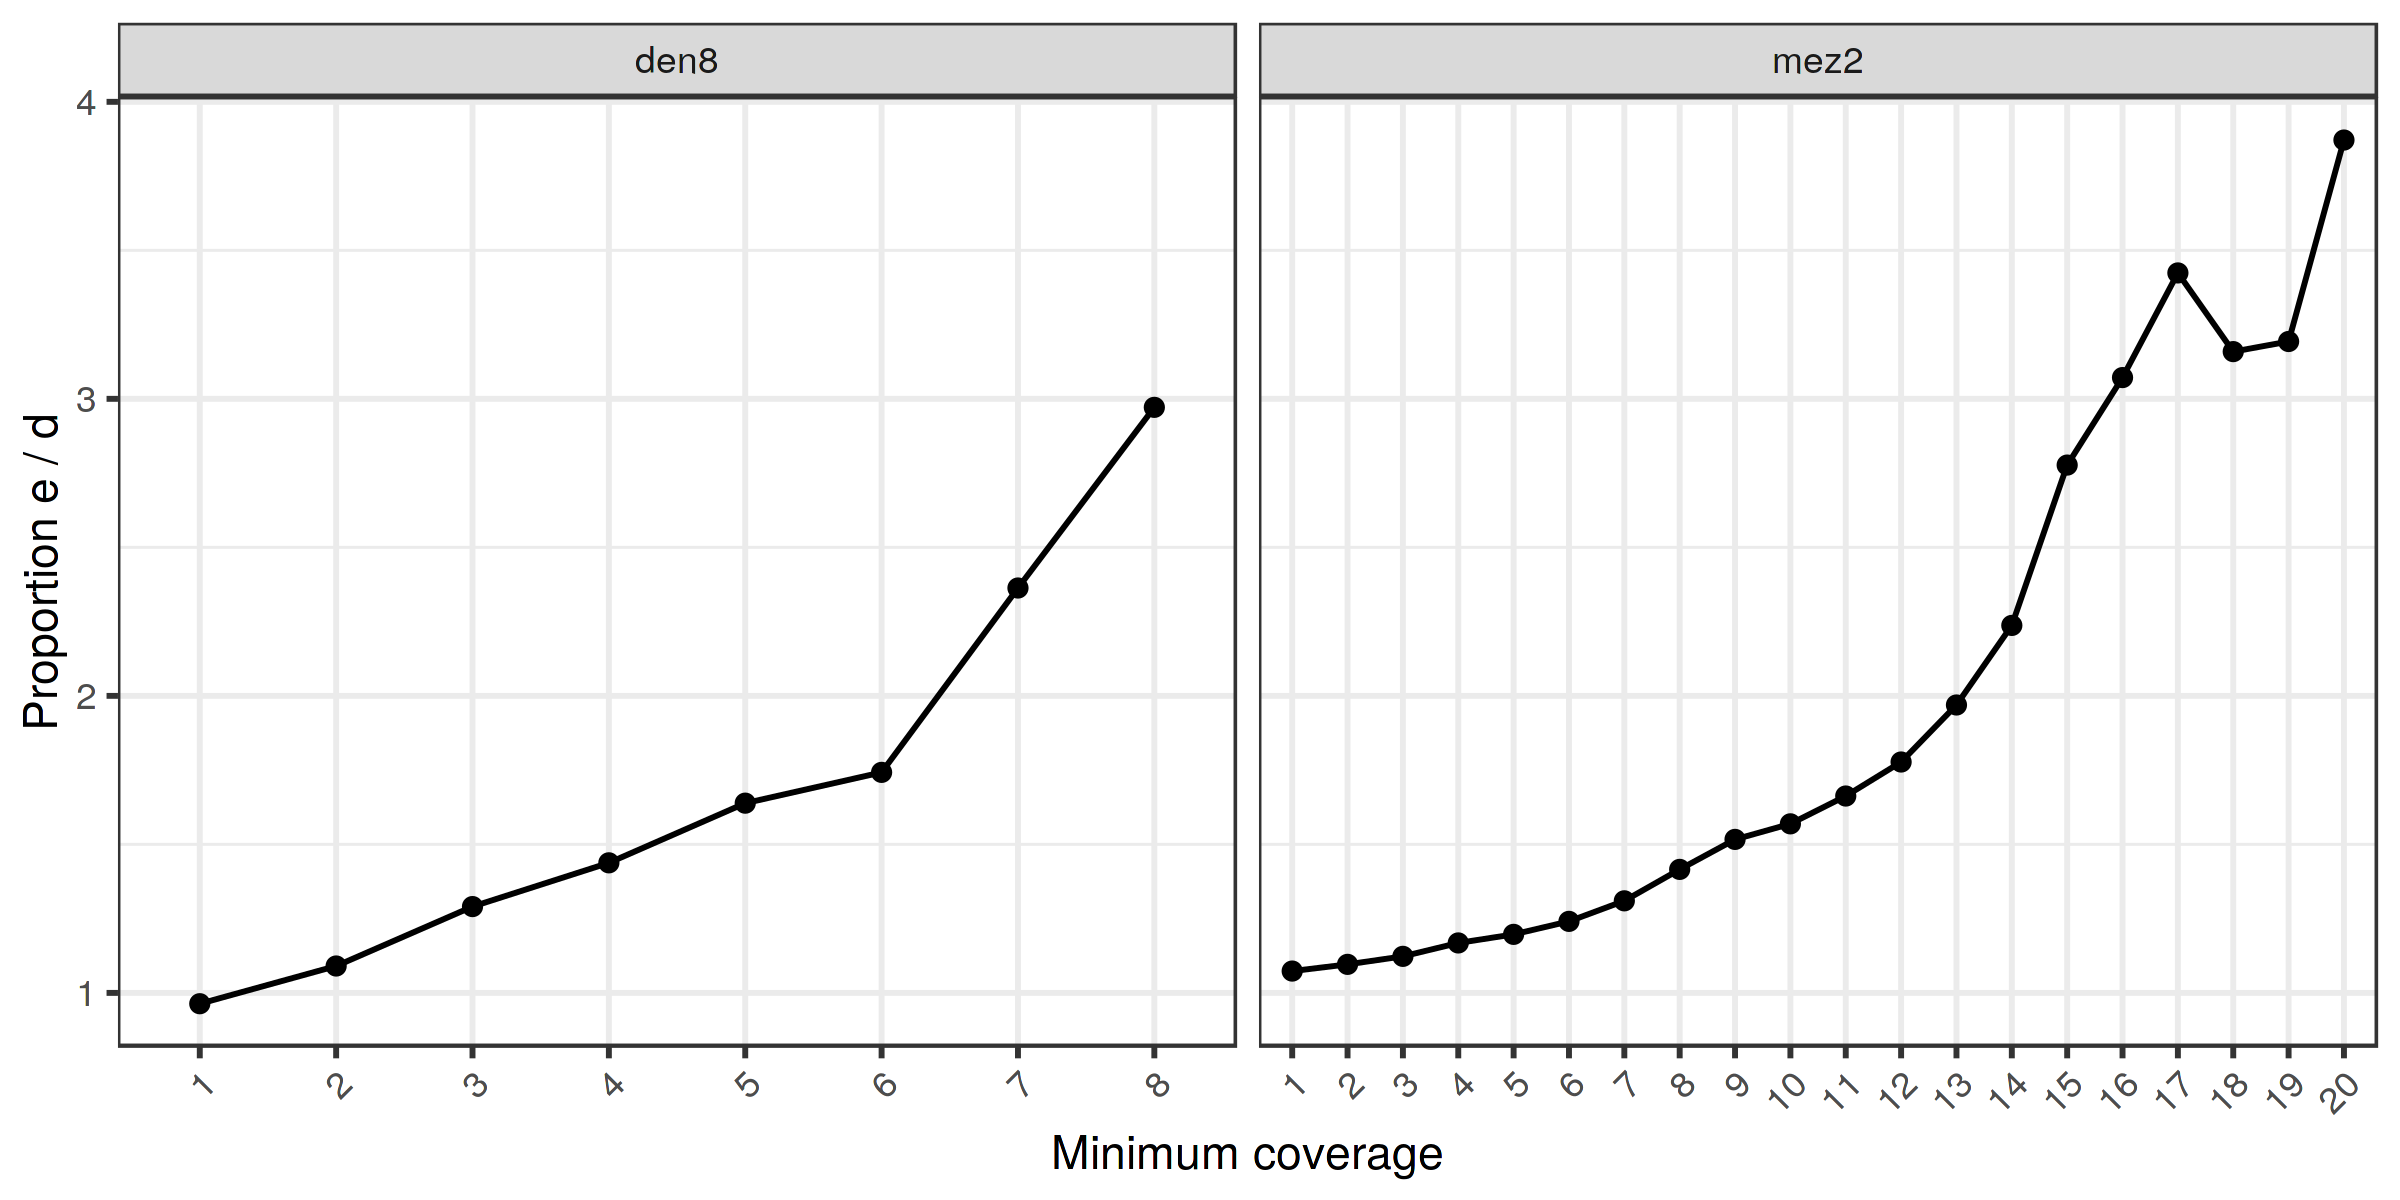

In [82]:
set_dim(8, 4)

tmrca_df %>%
filter(sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2")) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
group_by(arch, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = e / d) %>% 
ggplot(aes(as.factor(dp), prop)) +
    geom_point() +
    geom_line(group = 1) +
    facet_grid(. ~ arch, scales = "free_x") +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion e / d") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

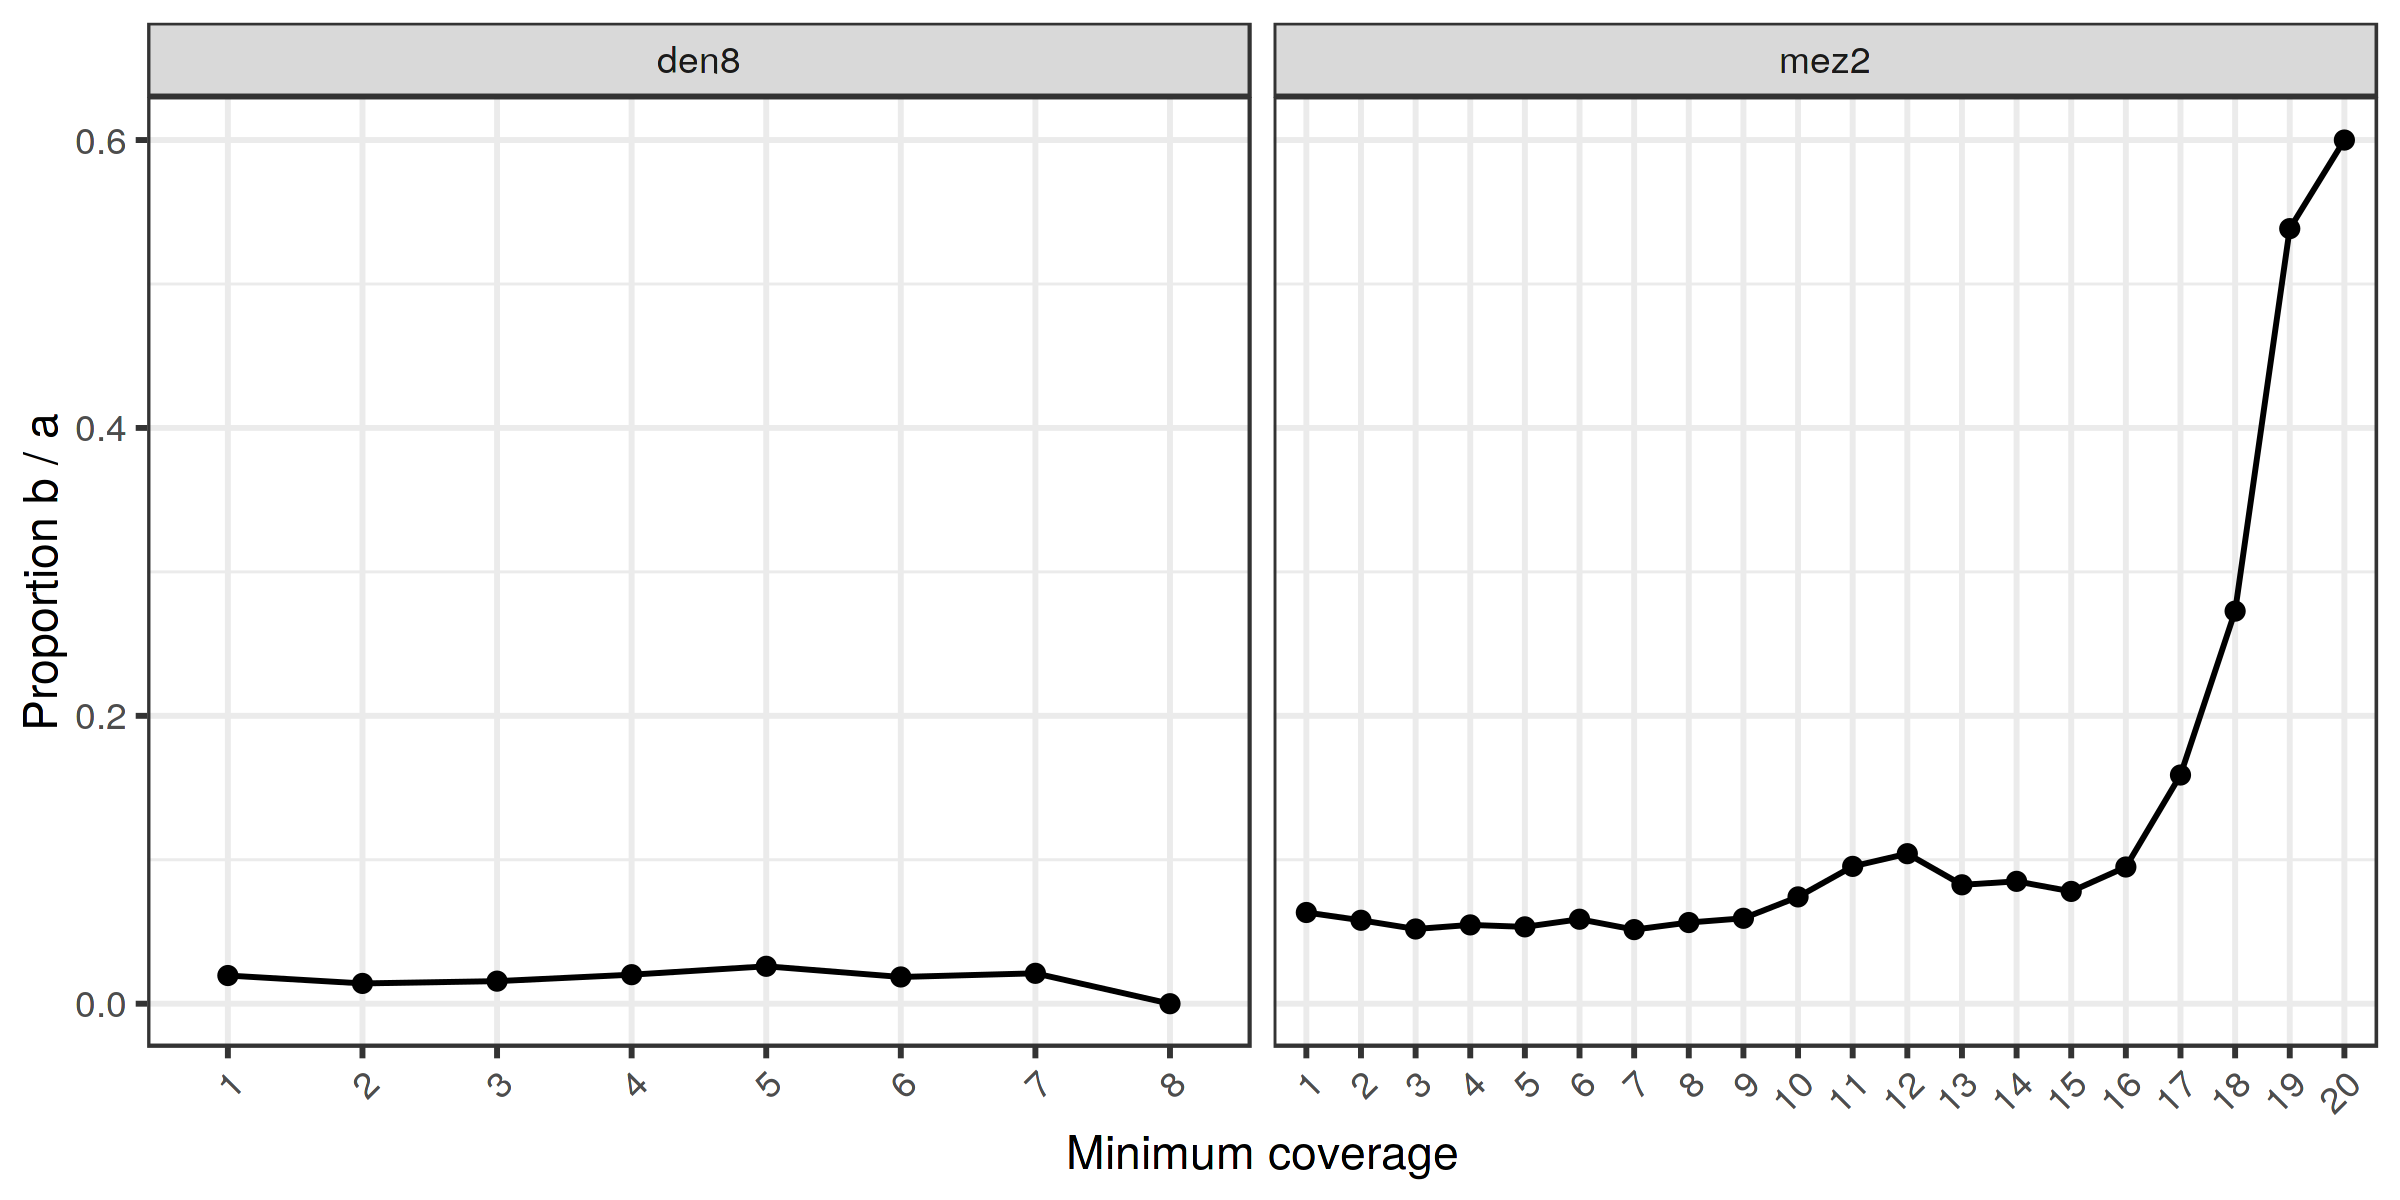

In [84]:
set_dim(8, 4)

tmrca_df %>%
filter(sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2")) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
group_by(arch, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = b / a) %>% 
ggplot(aes(as.factor(dp), prop)) +
    geom_point() +
    geom_line(group = 1) +
    facet_wrap(~ arch, scales = "free_x") +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion b / a") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

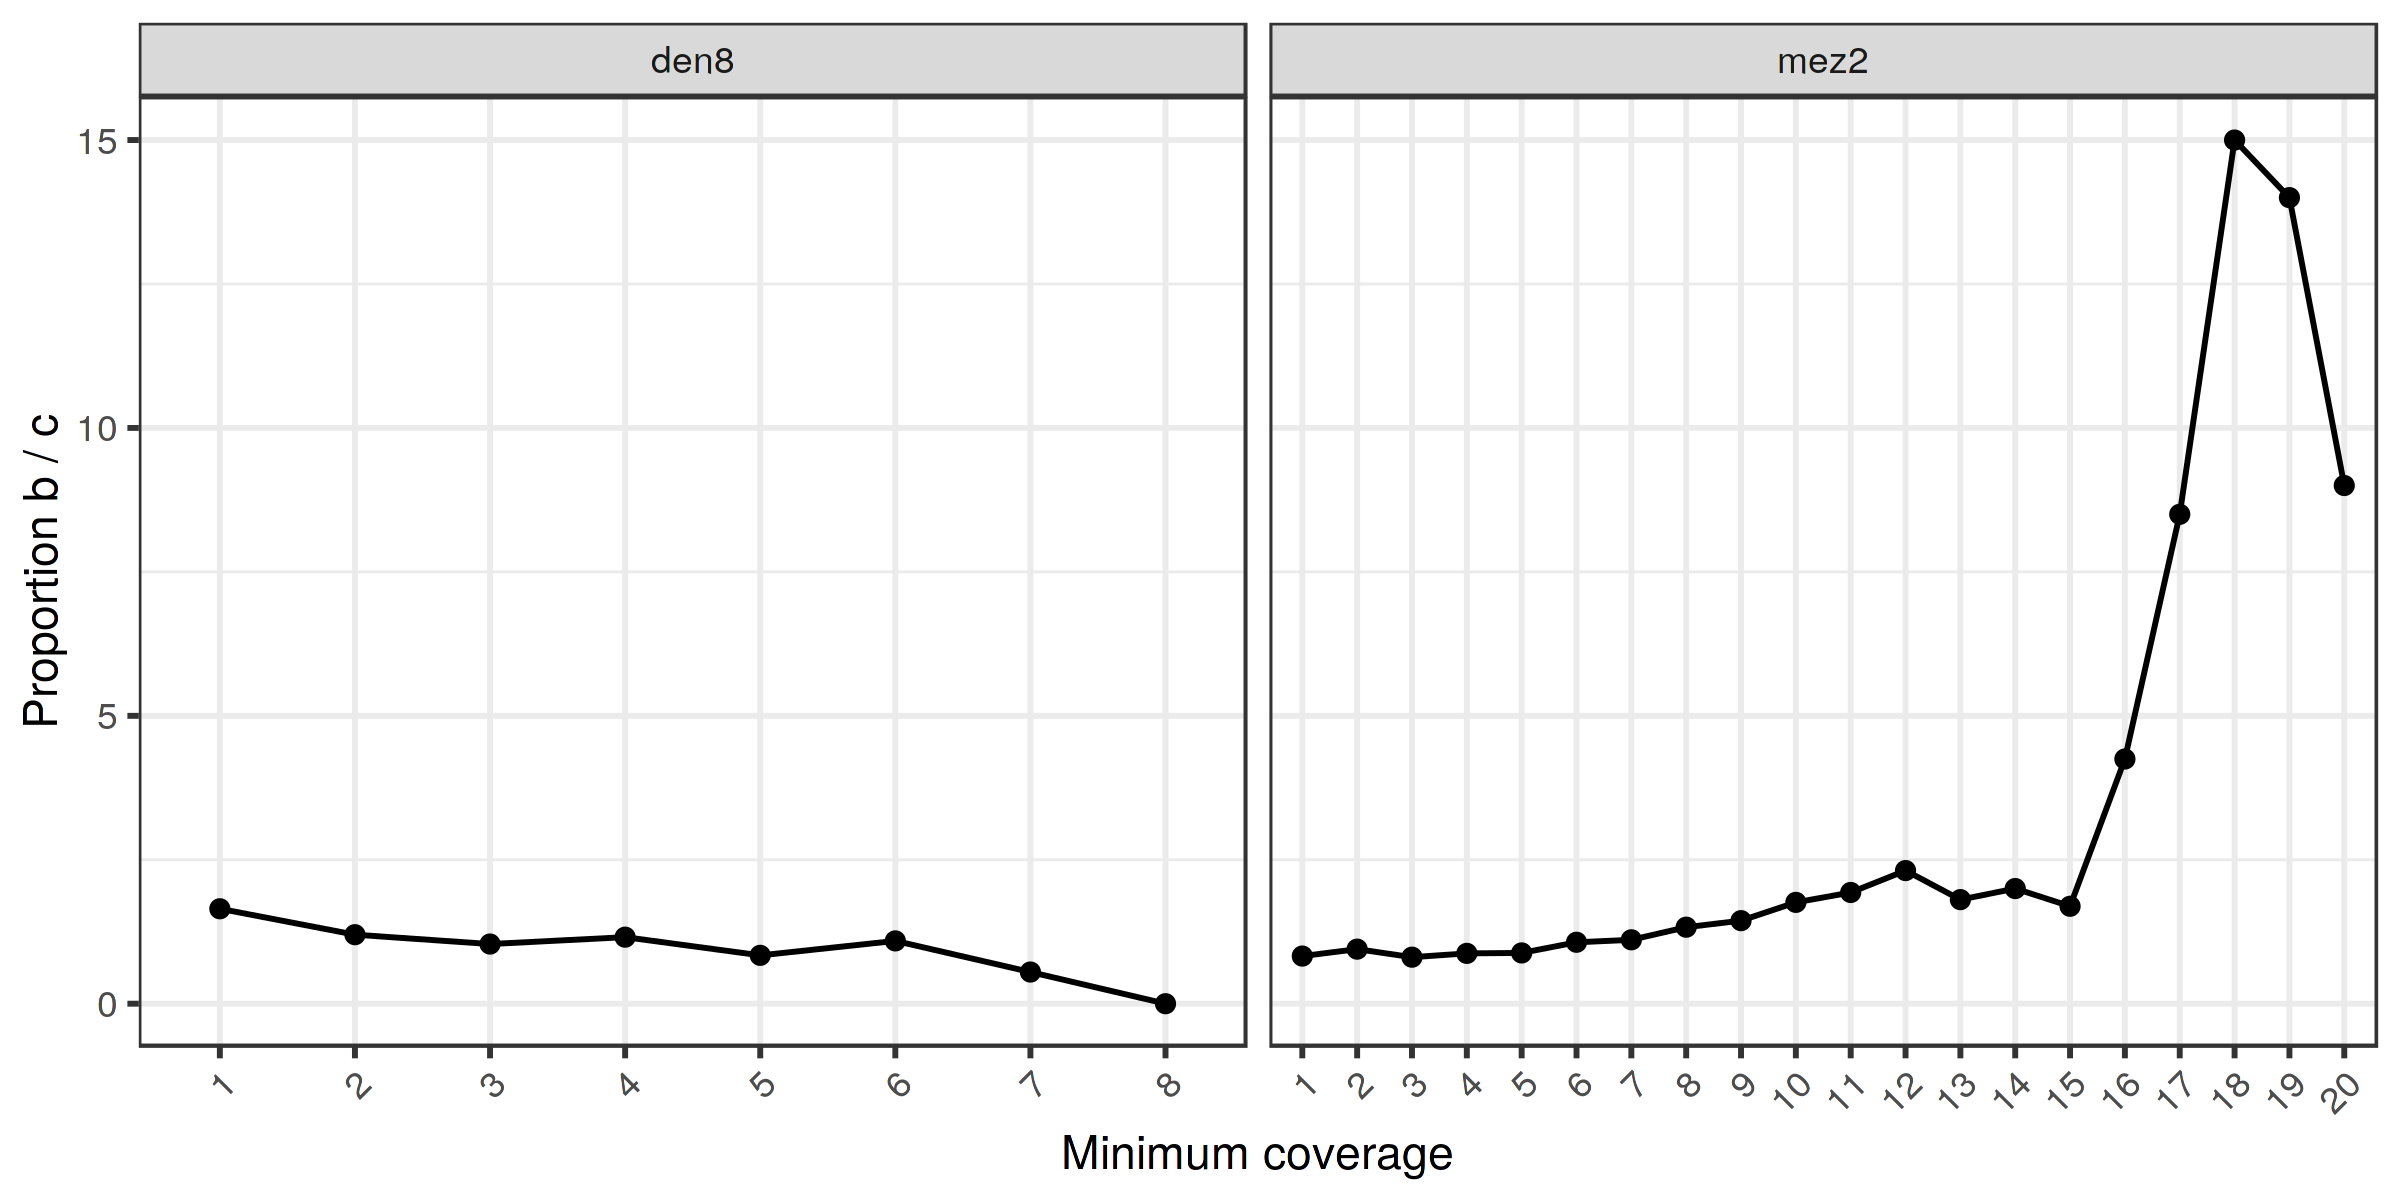

In [87]:
set_dim(8, 4)

tmrca_df %>%
filter(sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2")) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
group_by(arch, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = b / c) %>% 
ggplot(aes(as.factor(dp), prop)) +
    geom_point() +
    geom_line(group = 1) +
    facet_wrap(~ arch, scales = "free_x") +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion b / c") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

points here:

1. 3X coverage seems to remove most of the error effects nicely - best argument for using this cutoff in the middle panel.
2. TV-only removes all erors (TMRCA doesn't change) => sequencing errors minimal beyond aDNA damage.
3. Minimal effect of reference bias with increasing coverage??? Based on the Neanderthal line in the center panel, but significant bias in Denisova?

TMRCAs of A00 are overlapping the ones of other Africans, especially striking in the Lippold captures, but exome data looks weird too - too much noise in the data or not enough sequence to accumulate enough informative sites?